In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from adjustText import adjust_text

In [2]:
data = pd.read_excel('FY24 Attraction Level Set Injuries.xlsx')
df_attendance = pd.read_excel('FY24 Ridership.xlsx')

In [3]:
df_data = data[data['Division Desc'] == 'Epcot']

C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_24536\371992389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['severity_weight'] = np.exp(-(df_data['Severity Score'] - 1))  # Exponential decay weights
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


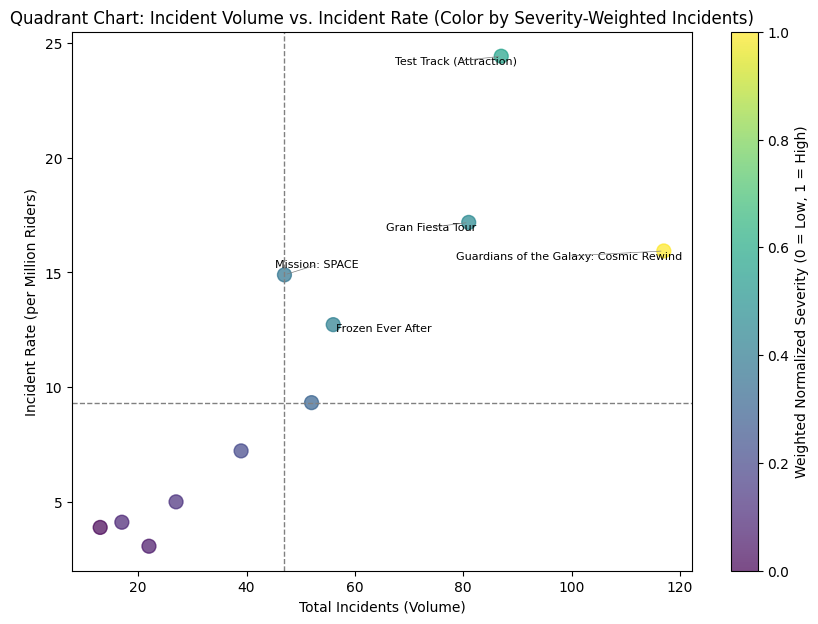

In [4]:
df_data['severity_weight'] = np.exp(-(df_data['Severity Score'] - 1))  # Exponential decay weights

# Step 2: Calculate the severity-weighted incident score for each attraction
# Group by 'Location Code Desc' and calculate the weighted sum (severity_weight * count of incidents)
grouped_data = df_data.groupby('Location Code Desc').agg(
    total_incidents=('Severity Score', 'count'),
    weighted_severity_sum=('severity_weight', 'sum')  # Sum of severity weights (accounts for both severity and volume)
).reset_index()

# Step 3: Normalize the weighted severity sum (so it fits between 0 and 1)
grouped_data['normalized_weighted_severity'] = (grouped_data['weighted_severity_sum'] - grouped_data['weighted_severity_sum'].min()) / (grouped_data['weighted_severity_sum'].max() - grouped_data['weighted_severity_sum'].min())

# Step 4: Merge with the attendance data to calculate rates and continue plotting
merged_df = pd.merge(grouped_data, df_attendance, left_on='Location Code Desc', right_on='Location')

# Calculate the incident rate per million riders
merged_df['incident_rate'] = (merged_df['total_incidents'] / merged_df['FY 2024']) * 1_000_000

# Plotting the quadrant chart with the severity-weighted incident score
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot with color representing normalized weighted severity sum
scatter = ax.scatter(
    merged_df['total_incidents'],        # X: Incident Volume
    merged_df['incident_rate'],          # Y: Incident Rate per million riders
    c=merged_df['normalized_weighted_severity'],  # Color by weighted normalized severity sum
    cmap='viridis',                      # Colormap for better visualization
    s=100,                               # Marker size
    alpha=0.7,
    vmin=0,                              # Force minimum of color scale to 0
    vmax=1                               # Force maximum of color scale to 1
)

# Adding labels to axes
ax.set_xlabel('Total Incidents (Volume)')
ax.set_ylabel('Incident Rate (per Million Riders)')

# Adding a colorbar for the weighted normalized severity score
cbar = plt.colorbar(scatter)
cbar.set_label('Weighted Normalized Severity (0 = Low, 1 = High)')

# Drawing lines to create quadrants based on median volume and rate
median_volume = merged_df['total_incidents'].median()
median_rate = merged_df['incident_rate'].median()

ax.axvline(median_volume, color='gray', linestyle='--', linewidth=1)  # Vertical line at median volume
ax.axhline(median_rate, color='gray', linestyle='--', linewidth=1)    # Horizontal line at median rate

# Prepare the list of texts for adjustText to adjust automatically
texts = []
for i, attraction in enumerate(merged_df['Location Code Desc']):
    # Label points where incident rate is above the median or severity is over 0.85
    if merged_df['incident_rate'].iloc[i] > median_rate or merged_df['normalized_weighted_severity'].iloc[i] > 0.85:
        texts.append(ax.text(
            merged_df['total_incidents'].iloc[i],
            merged_df['incident_rate'].iloc[i],
            attraction,
            fontsize=8,
            ha='center',
            va='center'
        ))

# Adjust text positions, restrict movement for better centering, and add arrows connecting to dots
adjust_text(texts, 
            force_text=(0.3, 0.3),   # Force factor for minimal movement (closer to the center)
            only_move={'points':'xy', 'texts':'xy'},  # Restrict to movement in both x and y axes
            expand_points=(1.2, 1.2),  # Avoid too much expansion away from points
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))  # Adds small lines from label to point

# Title of the plot
plt.title('Quadrant Chart: Incident Volume vs. Incident Rate (Color by Severity-Weighted Incidents)')

plt.show()